In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
dataset_dir = r'C:\Users\ranjana\Downloads\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset'

def create_dataframe_from_directory(directory):

    filepaths = []

    labels = []

    for label in os.listdir(directory):

        class_dir = os.path.join(directory, label)

        if os.path.isdir(class_dir):

            for file in os.listdir(class_dir):

                filepaths.append(os.path.join(class_dir, file))

                labels.append(label)  

    return pd.DataFrame({"filepaths": filepaths, "labels": labels})

data = create_dataframe_from_directory(dataset_dir)

train_set, temp_set = train_test_split(data, test_size=0.3, stratify=data['labels'], random_state=42)

val_set, test_images = train_test_split(temp_set, test_size=0.5, stratify=temp_set['labels'], random_state=42)

train_set = train_set.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Training samples: {len(train_set)}")

print(f"Validation samples: {len(val_set)}")

print(f"Testing samples: {len(test_images)}")

Training samples: 767
Validation samples: 165
Testing samples: 165


In [3]:

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
train = image_gen.flow_from_dataframe(

    dataframe=train_set,

    x_col="filepaths",

    y_col="labels",

    target_size=(224, 224),

    color_mode='rgb',

    class_mode="categorical",

    batch_size=32,

    shuffle=True

)

val = image_gen.flow_from_dataframe(

    dataframe=val_set,

    x_col="filepaths",

    y_col="labels",

    target_size=(224, 224),

    color_mode='rgb',

    class_mode="categorical",

    batch_size=32,

    shuffle=False

)

test = image_gen.flow_from_dataframe(

    dataframe=test_images,

    x_col="filepaths",

    y_col="labels",

    target_size=(224, 224),

    color_mode='rgb',

    class_mode="categorical",

    batch_size=32,

    shuffle=False

)

Found 767 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.


In [ ]:
def create_cnn(input_shape, num_classes):

    model = Sequential([

        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),

        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation="relu"),

        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation="relu"),

        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(128, activation="relu"),

        Dropout(0.5),

        Dense(num_classes, activation="softmax"),

    ])

    return model


def create_advanced_cnn(input_shape, num_classes):

    model = Sequential([

        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),

        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation="relu"),

        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation="relu"),

        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation="relu"),

        MaxPooling2D((2, 2)),

        Conv2D(512, (3, 3), activation="relu"),

        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(512, activation="relu"),

        Dropout(0.5),

        Dense(num_classes, activation="softmax"),

    ])

    return model

def create_hybrid_model(input_shape, num_classes):

    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

    base_model.trainable = False  



    model = Sequential([

        base_model,


        Conv2D(32, (3, 3), activation="relu", padding="same"),

        MaxPooling2D((2, 2)),



        Conv2D(64, (3, 3), activation="relu", padding="same"),

        MaxPooling2D((2, 2)),



        Conv2D(128, (3, 3), activation="relu", padding="same"),

        GlobalAveragePooling2D(),



        Dense(128, activation="relu"),

        Dropout(0.5),



        Dense(num_classes, activation="softmax"),

    ])

    return model


model_save_dir = "./models123"

os.makedirs(model_save_dir, exist_ok=True)

results = {}

trained_models = {}



model_architectures = {

  "BasicCNN": create_cnn,

"Advanced_CNN":create_advanced_cnn,

"ResNet50": create_hybrid_model

}


for model_name, create_model in model_architectures.items():

    print(f"Training {model_name}...")

    base_model = create_model((224, 224, 3), len(train.class_indices))

    base_model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])


    history = base_model.fit(train, validation_data=val, epochs=20, callbacks=[

        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    ])



    base_model.save(os.path.join(model_save_dir, f"{model_name}.keras"))

    trained_models[model_name] = base_model


    val_loss, val_accuracy = base_model.evaluate(val)

    results[model_name] = {"accuracy": val_accuracy, "loss": val_loss, "history": history}


for model_name, model in trained_models.items():

    preds = model.predict(val)

    y_pred = preds.argmax(axis=1)

    y_true = val.classes

    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))

    print(f"Confusion Matrix for {model_name}:\n", confusion_matrix(y_true, y_pred))

Training BasicCNN...


C:\Users\ranjana\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


C:\Users\ranjana\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4602 - loss: 283.6195 - val_accuracy: 0.7212 - val_loss: 0.7277
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7199 - loss: 0.6758 - val_accuracy: 0.8667 - val_loss: 0.4498
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8537 - loss: 0.3893 - val_accuracy: 0.8970 - val_loss: 0.2913
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9332 - loss: 0.1982 - val_accuracy: 0.9030 - val_loss: 0.2500
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9667 - loss: 0.1223 - val_accuracy: 0.9091 - val_loss: 0.3380
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9826 - loss: 0.0567 - val_accuracy: 0.9515 - val_loss: 0.3196
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9876 - loss: 0.0411 - val_accuracy: 0.9515 - val_loss: 0.3414
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9876 - loss: 0.0257 - val_accuracy: 0.9576 - val_loss: 0.3262
E

In [5]:
import os

import numpy as np

import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

model_save_dir = "./models123"

loaded_models = {}

for file in os.listdir(model_save_dir):

    if file.endswith(".keras"):

        model_name = file.split(".keras")[0]

        loaded_models[model_name] = load_model(os.path.join(model_save_dir, file))

        print(f"Loaded {model_name} model.")


metrics = {}

for model_name, model in loaded_models.items():

    print(f"\nEvaluating {model_name}...")

    preds = model.predict(val)

    y_pred = preds.argmax(axis=1)

    y_true = val.classes

    report = classification_report(y_true, y_pred, output_dict=True)

    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)

    print(f"Confusion Matrix for {model_name}:\n", cm)

    accuracy = accuracy_score(y_true, y_pred)

    precision = precision_score(y_true, y_pred, average="weighted")

    recall = recall_score(y_true, y_pred, average="weighted")

    f1 = f1_score(y_true, y_pred, average="weighted")

    print(f"Metrics Summary for {model_name}:")

    print(f"  - Accuracy: {accuracy:.4f}")

    print(f"  - Precision (Weighted): {precision:.4f}")

    print(f"  - Recall (Weighted): {recall:.4f}")

    print(f"  - F1-Score (Weighted): {f1:.4f}")


    metrics[model_name] = {

        "y_true": y_true,

        "y_pred": y_pred,

        "accuracy": accuracy,

        "precision": precision,

        "recall": recall,

        "f1": f1,

    }


def ensemble_predictions(models, val_data):

    ensemble_preds = None

    for model in models.values():

        preds = model.predict(val_data)

        ensemble_preds = preds if ensemble_preds is None else ensemble_preds + preds

    return ensemble_preds / len(models)



print("\nCalculating Ensemble Predictions...")

ensemble_preds = ensemble_predictions(loaded_models, val)

ensemble_y_pred = ensemble_preds.argmax(axis=1)

ensemble_accuracy = accuracy_score(y_true, ensemble_y_pred)

ensemble_precision = precision_score(y_true, ensemble_y_pred, average="weighted")

ensemble_recall = recall_score(y_true, ensemble_y_pred, average="weighted")

ensemble_f1 = f1_score(y_true, ensemble_y_pred, average="weighted")



print("\nEnsemble Classification Report:\n", classification_report(y_true, ensemble_y_pred))

print("\nEnsemble Confusion Matrix:\n", confusion_matrix(y_true, ensemble_y_pred))

print(f"\nEnsemble Performance Metrics:")

print(f"  - Accuracy: {ensemble_accuracy:.4f}")

print(f"  - Precision (Weighted): {ensemble_precision:.4f}")

print(f"  - Recall (Weighted): {ensemble_recall:.4f}")

print(f"  - F1-Score (Weighted): {ensemble_f1:.4f}")


Loaded Advanced_CNN model.
Loaded BasicCNN model.
Loaded ResNet50 model.

Evaluating Advanced_CNN...
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step
Classification Report for Advanced_CNN:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.99      1.00      0.99        84
           2       1.00      0.98      0.99        63

    accuracy                           0.99       165
   macro avg       1.00      0.99      1.00       165
weighted avg       0.99      0.99      0.99       165

Confusion Matrix for Advanced_CNN:
 [[18  0  0]
 [ 0 84  0]
 [ 0  1 62]]
Metrics Summary for Advanced_CNN:
  - Accuracy: 0.9939
  - Precision (Weighted): 0.9940
  - Recall (Weighted): 0.9939
  - F1-Score (Weighted): 0.9939

Evaluating BasicCNN...
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step
Classification Report for BasicCNN:
               precision    recall  f1-score   support

           0       0.77      0.56      0.65        18
      

In [6]:
import os

import numpy as np

from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

model_save_dir = "./models123"

test_metrics = {}

loaded_models = {}

for model_name in os.listdir(model_save_dir):

    if model_name.endswith(".keras"):

        model_path = os.path.join(model_save_dir, model_name)

        model = load_model(model_path)

        loaded_models[model_name] = model



        print(f"Evaluating {model_name} on the test set...")

        preds = model.predict(test, steps=len(test), verbose=1)

        y_pred = np.argmax(preds, axis=1)

        y_true = test.classes

        print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))

        print(f"Confusion Matrix for {model_name}:\n", confusion_matrix(y_true, y_pred))

        accuracy = accuracy_score(y_true, y_pred)

        precision = precision_score(y_true, y_pred, average="weighted")

        recall = recall_score(y_true, y_pred, average="weighted")

        f1 = f1_score(y_true, y_pred, average="weighted")

        print(f"Metrics Summary for {model_name}:")

        print(f"  - Accuracy: {accuracy:.4f}")

        print(f"  - Precision (Weighted): {precision:.4f}")

        print(f"  - Recall (Weighted): {recall:.4f}")

        print(f"  - F1-Score (Weighted): {f1:.4f}\n")

        test_metrics[model_name] = {

            "accuracy": accuracy,

            "precision": precision,

            "recall": recall,

            "f1": f1

        }

print("\nPerforming ensemble prediction on the test set...")



ensemble_preds = None

for model_name, model in loaded_models.items():

    preds = model.predict(test, steps=len(test), verbose=1)

    if ensemble_preds is None:

        ensemble_preds = preds

    else:

        ensemble_preds += preds


ensemble_preds /= len(loaded_models)

ensemble_y_pred = np.argmax(ensemble_preds, axis=1)

y_true = test.classes

ensemble_accuracy = accuracy_score(y_true, ensemble_y_pred)

ensemble_precision = precision_score(y_true, ensemble_y_pred, average="weighted")

ensemble_recall = recall_score(y_true, ensemble_y_pred, average="weighted")

ensemble_f1 = f1_score(y_true, ensemble_y_pred, average="weighted")



print("\nEnsemble Metrics Summary:")

print(f"  - Accuracy: {ensemble_accuracy:.4f}")

print(f"  - Precision (Weighted): {ensemble_precision:.4f}")

print(f"  - Recall (Weighted): {ensemble_recall:.4f}")

print(f"  - F1-Score (Weighted): {ensemble_f1:.4f}\n")

Evaluating Advanced_CNN.keras on the test set...


C:\Users\ranjana\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step
Classification Report for Advanced_CNN.keras:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       1.00      1.00      1.00        85
           2       0.98      1.00      0.99        62

    accuracy                           0.99       165
   macro avg       0.99      0.98      0.99       165
weighted avg       0.99      0.99      0.99       165

Confusion Matrix for Advanced_CNN.keras:
 [[17  0  1]
 [ 0 85  0]
 [ 0  0 62]]
Metrics Summary for Advanced_CNN.keras:
  - Accuracy: 0.9939
  - Precision (Weighted): 0.9940
  - Recall (Weighted): 0.9939
  - F1-Score (Weighted): 0.9939

Evaluating BasicCNN.keras on the test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step
Classification Report for BasicCNN.keras:
               precision    recall  f1-score   support

           0       0.92      0.67      0.77        18
           1       0.99      0.93      0.96        85
       

In [7]:
import numpy as np
import os  
def save_image_gen_data(generator, save_dir, dataset_name):
   
    images = []
    labels = []

    for _ in range(len(generator)):
        x_batch, y_batch = next(generator) 
        images.append(x_batch)
        labels.append(y_batch)

    images = np.concatenate(images)
    labels = np.concatenate(labels)

    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, f"{dataset_name}_images.npy"), images)
    np.save(os.path.join(save_dir, f"{dataset_name}_labels.npy"), labels)
    print(f"Saved {dataset_name} data to {save_dir}.")

save_dir = "./saved_data1"

save_image_gen_data(train, save_dir, "train")
save_image_gen_data(val, save_dir, "val")
save_image_gen_data(test, save_dir, "test")


Saved train data to ./saved_data1.
Saved val data to ./saved_data1.
Saved test data to ./saved_data1.


In [8]:
import os

import numpy as np

from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

save_dir = "./saved_data1"

test_images = np.load(os.path.join(save_dir, "test_images.npy"))

test_labels = np.load(os.path.join(save_dir, "test_labels.npy"))

print(f"Test images shape: {test_images.shape}")

print(f"Test labels shape: {test_labels.shape}")

model_dir = "./models123"

model_files = [file for file in os.listdir(model_dir) if file.endswith(".keras")]

test_metrics = {}

ensemble_preds = None

for model_file in model_files:

    model_name = model_file.split(".keras")[0]

    print(f"\nEvaluating {model_name} on the test set...")

    model_path = os.path.join(model_dir, model_file)

    model = load_model(model_path)

    preds = model.predict(test_images)

    y_pred = np.argmax(preds, axis=1)

    y_true = np.argmax(test_labels, axis=1)

    if ensemble_preds is None:

        ensemble_preds = preds

    else:

        ensemble_preds += preds


    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))

    print(f"Confusion Matrix for {model_name}:\n", confusion_matrix(y_true, y_pred))

    accuracy = accuracy_score(y_true, y_pred)

    precision = precision_score(y_true, y_pred, average="weighted")

    recall = recall_score(y_true, y_pred, average="weighted")

    f1 = f1_score(y_true, y_pred, average="weighted")



    print(f"Metrics Summary for {model_name}:")

    print(f"  - Accuracy: {accuracy:.4f}")

    print(f"  - Precision (Weighted): {precision:.4f}")

    print(f"  - Recall (Weighted): {recall:.4f}")

    print(f"  - F1-Score (Weighted): {f1:.4f}\n")


    test_metrics[model_name] = {

        "accuracy": accuracy,

        "precision": precision,

        "recall": recall,

        "f1": f1

    }

print("\nPerforming ensemble prediction on the test set...")

ensemble_preds /= len(model_files)  

ensemble_y_pred = np.argmax(ensemble_preds, axis=1)

y_true = np.argmax(test_labels, axis=1)

ensemble_accuracy = accuracy_score(y_true, ensemble_y_pred)

ensemble_precision = precision_score(y_true, ensemble_y_pred, average="weighted")

ensemble_recall = recall_score(y_true, ensemble_y_pred, average="weighted")

ensemble_f1 = f1_score(y_true, ensemble_y_pred, average="weighted")

print("\nEnsemble Metrics Summary:")

print(f"  - Accuracy: {ensemble_accuracy:.4f}")

print(f"  - Precision (Weighted): {ensemble_precision:.4f}")

print(f"  - Recall (Weighted): {ensemble_recall:.4f}")

print(f"  - F1-Score (Weighted): {ensemble_f1:.4f}\n")

Test images shape: (165, 224, 224, 3)
Test labels shape: (165, 3)

Evaluating Advanced_CNN on the test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step
Classification Report for Advanced_CNN:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       1.00      1.00      1.00        85
           2       0.98      1.00      0.99        62

    accuracy                           0.99       165
   macro avg       0.99      0.98      0.99       165
weighted avg       0.99      0.99      0.99       165

Confusion Matrix for Advanced_CNN:
 [[17  0  1]
 [ 0 85  0]
 [ 0  0 62]]
Metrics Summary for Advanced_CNN:
  - Accuracy: 0.9939
  - Precision (Weighted): 0.9940
  - Recall (Weighted): 0.9939
  - F1-Score (Weighted): 0.9939


Evaluating BasicCNN on the test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step
Classification Report for BasicCNN:
               precision    recall  f1-score   support

           0       0.92      0.67 

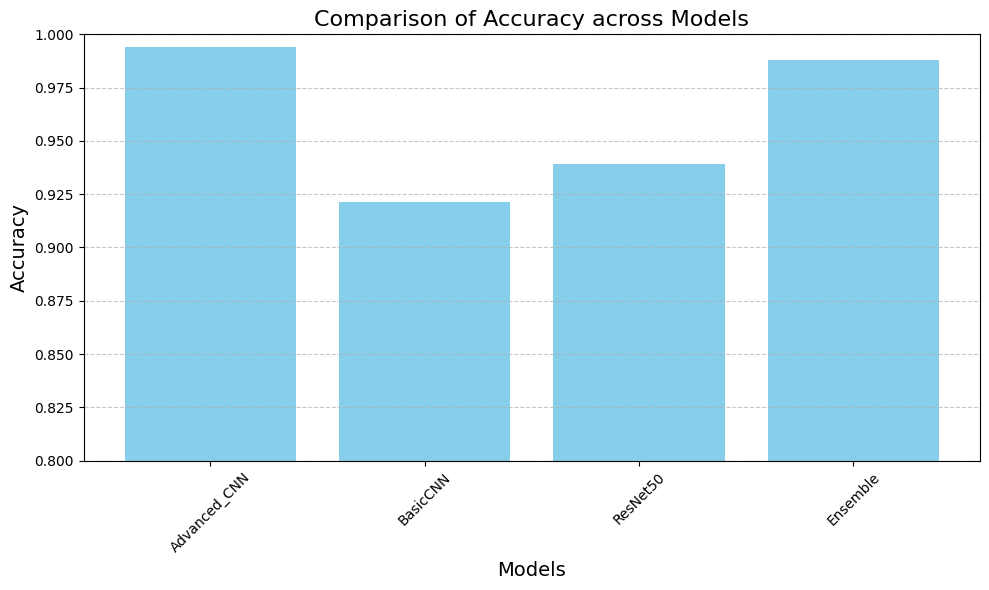

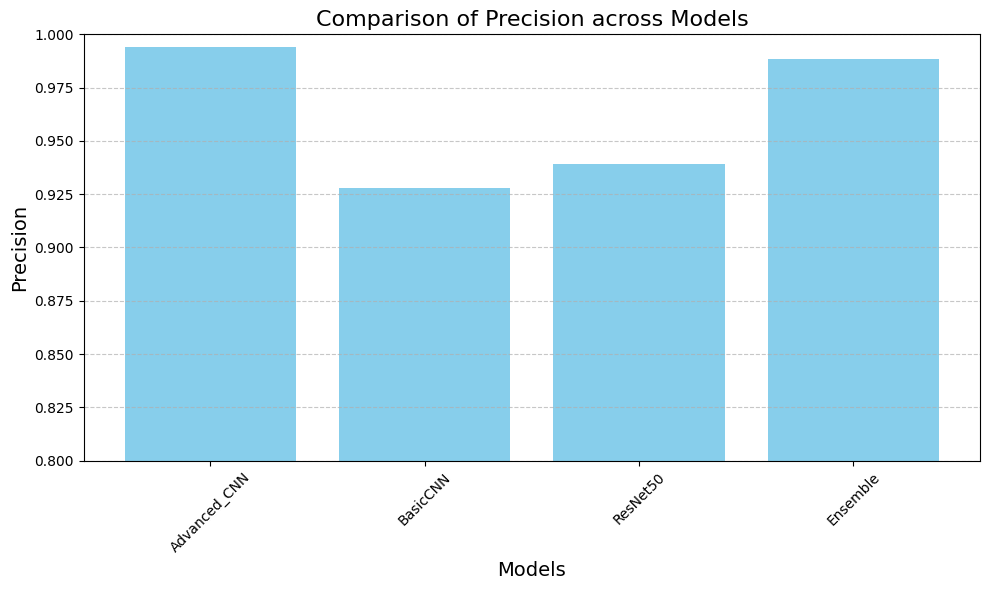

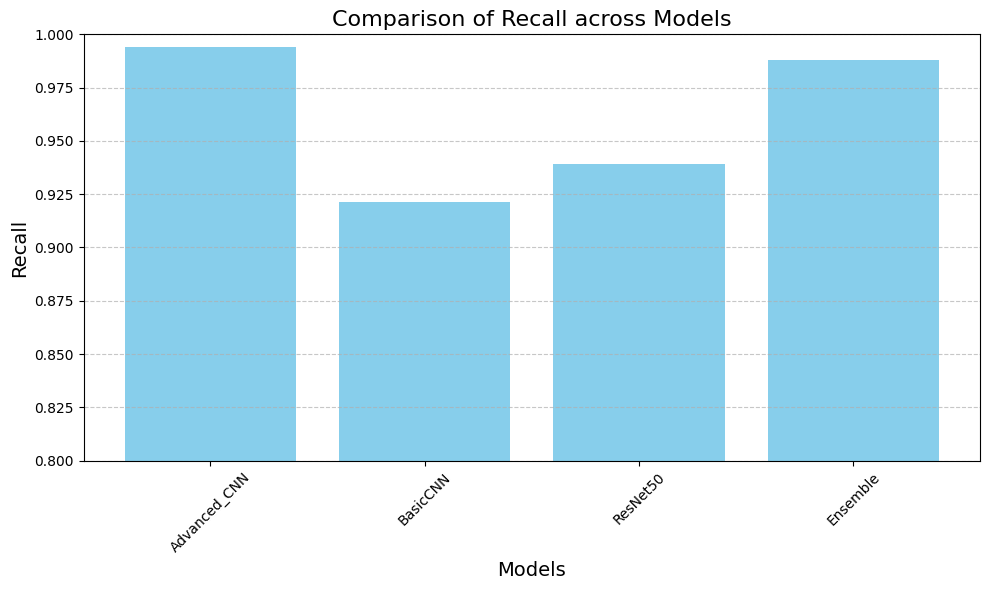

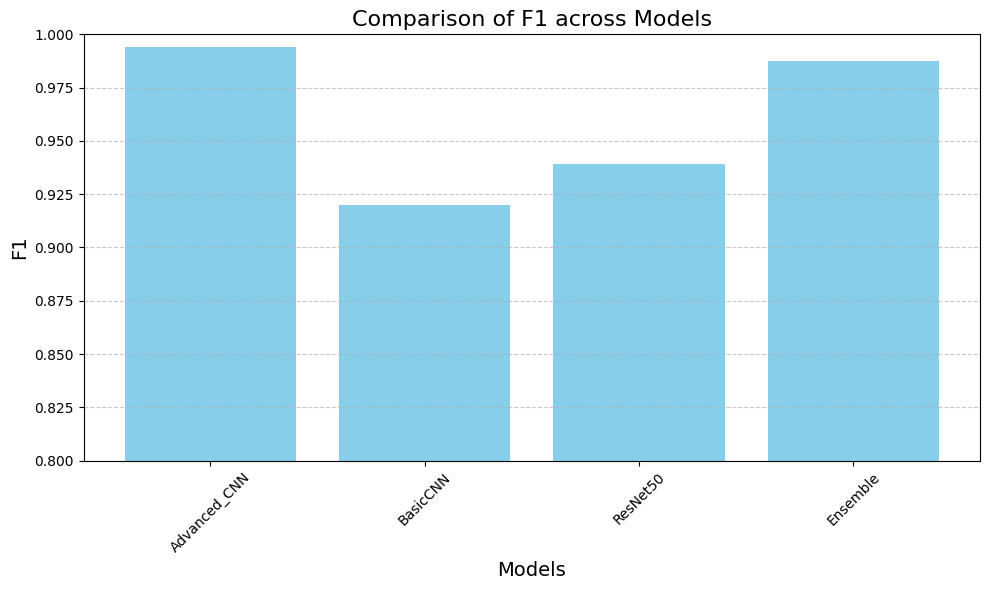

In [9]:
test_metrics["Ensemble"] = {

    "accuracy": ensemble_accuracy,

    "precision": ensemble_precision,

    "recall": ensemble_recall,

    "f1": ensemble_f1

}

metric_names = ["accuracy", "precision", "recall", "f1"]

for metric in metric_names:

    plt.figure(figsize=(10, 6))

    model_names = list(test_metrics.keys())

    metric_values = [test_metrics[m][metric] for m in model_names]

    plt.bar(model_names, metric_values, color="skyblue")

    plt.title(f"Comparison of {metric.capitalize()} across Models", fontsize=16)

    plt.xlabel("Models", fontsize=14)

    plt.ylabel(metric.capitalize(), fontsize=14)

    plt.xticks(rotation=45)

    plt.ylim(0.8, 1.0)  

    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()

    plt.show()

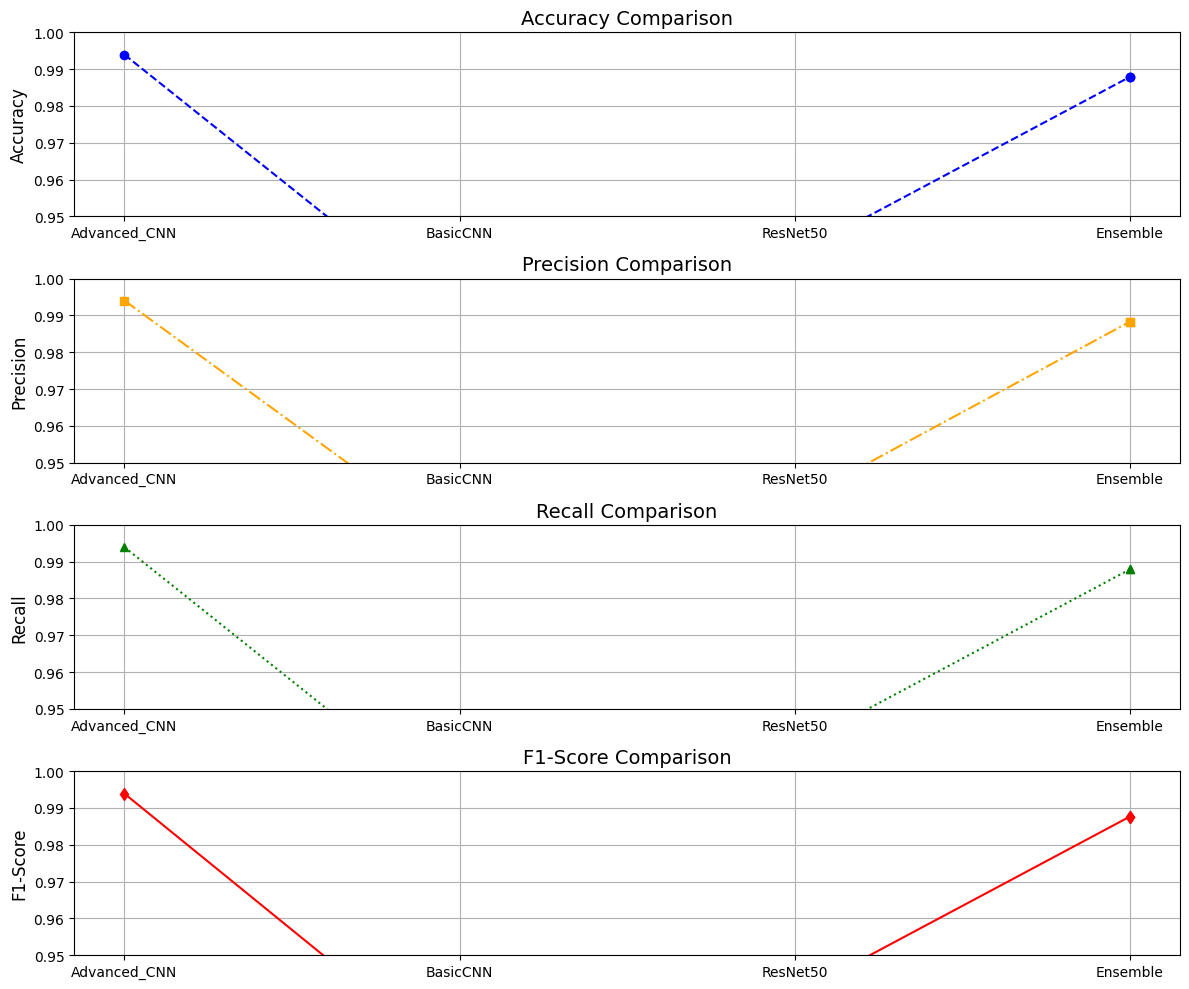

In [10]:
import matplotlib.pyplot as plt

model_names = list(test_metrics.keys())

accuracies = [test_metrics[model]["accuracy"] for model in model_names]

precisions = [test_metrics[model]["precision"] for model in model_names]

recalls = [test_metrics[model]["recall"] for model in model_names]

f1_scores = [test_metrics[model]["f1"] for model in model_names]

model_names.append("Ensemble")

accuracies.append(ensemble_accuracy)

precisions.append(ensemble_precision)

recalls.append(ensemble_recall)

f1_scores.append(ensemble_f1)

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)

plt.plot(model_names, accuracies, marker="o", linestyle="--", label="Accuracy", color="blue")

plt.title("Accuracy Comparison", fontsize=14)

plt.ylim(0.95, 1.0)

plt.ylabel("Accuracy", fontsize=12)

plt.grid(True)

plt.subplot(4, 1, 2)

plt.plot(model_names, precisions, marker="s", linestyle="-.", label="Precision", color="orange")

plt.title("Precision Comparison", fontsize=14)

plt.ylim(0.95, 1.0)

plt.ylabel("Precision", fontsize=12)

plt.grid(True)

plt.subplot(4, 1, 3)

plt.plot(model_names, recalls, marker="^", linestyle=":", label="Recall", color="green")

plt.title("Recall Comparison", fontsize=14)

plt.ylim(0.95, 1.0)

plt.ylabel("Recall", fontsize=12)

plt.grid(True)

plt.subplot(4, 1, 4)

plt.plot(model_names, f1_scores, marker="d", linestyle="-", label="F1-Score", color="red")

plt.title("F1-Score Comparison", fontsize=14)

plt.ylim(0.95, 1.0)

plt.ylabel("F1-Score", fontsize=12)

plt.grid(True)

plt.tight_layout()

plt.show()

In [1]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import os

model_dir = r"C:\Users\ranjana\models123"
model_files = [file for file in os.listdir(model_dir) if file.endswith(".keras")]
models = {file.split(".keras")[0]: load_model(os.path.join(model_dir, file)) for file in model_files}

class_mapping = {

    0: "Benign case",

    1: "Malignant case",

    2: "Normal case"

}

def preprocess_image(image, target_size=(224, 224)):
    
    img = image.resize(target_size)

    img_array = img_to_array(img) 

    img_array = np.expand_dims(img_array, axis=0) 

    img_array = tf.keras.applications.resnet50.preprocess_input(img_array) 

    return img_array


def classify_image(image):

    processed_image = preprocess_image(image)

    individual_results = {}

    ensemble_preds = None

    for model_name, model in models.items():

        preds = model.predict(processed_image)

        individual_results[model_name] = preds

        if ensemble_preds is None:

            ensemble_preds = preds

        else:

            ensemble_preds += preds

    ensemble_preds /= len(models)

    ensemble_class = ensemble_preds.argmax(axis=1)[0]

    results = []

    for model_name, preds in individual_results.items():

        class_pred = preds.argmax(axis=1)[0]

        confidence = preds.max()

        class_name = class_mapping[class_pred]

        results.append(f"{model_name}: {class_name} (Confidence: {confidence:.4f})")

    ensemble_class_name = class_mapping[ensemble_class]

    ensemble_result = f"Ensemble Prediction: {ensemble_class_name} (Confidence: {ensemble_preds.max():.4f})"

    return "\n".join(results), ensemble_result

frontend = gr.Interface(

    fn=classify_image,

    inputs=gr.Image(type="pil"),  

    outputs=[

        gr.Textbox(label="Individual Model Predictions"), 

        gr.Label(label="Ensemble Prediction")  

    ],

    title="Lung Cancer Classification Frontend",

    description="Upload a lung scan image to classify it as Benign, Malignant, or Normal using individual models and ensemble predictions."

)

frontend.launch(share=True) 


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d5866ce468a991c695.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
